In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix, classification_report, make_scorer
import pickle
import os
import plotly.graph_objects as go
import plotly.express as px
from typing import Dict, List, Tuple, Any, Optional

In [2]:
# Define the absolute path for saving models
MODELS_DIR = r"C:\Users\alex5\Documents\Projects\telecom_churn_project\telecom_churn\models"

# Create the models directory if it doesn't exist
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
    print(f"Created models directory at {MODELS_DIR}")

In [3]:
# Load the data
data = pd.read_csv("../data/cell2celltrain.csv")
data.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


In [4]:
# Preprocessing
data = data.drop('CustomerID', axis=1)

# Handle missing values
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].fillna('Unknown')

# Convert categorical features to numerical features
for col in data.columns:
    if data[col].dtype == 'object':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])

In [5]:
# Define features and target
X = data.drop('Churn', axis=1)
y = data['Churn']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Scale numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# Define models (4 models, no Neural Network)
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Define hyperparameter grids
param_grids = {
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.3]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.3]}
}

# Define scoring metrics
scoring = ['roc_auc', 'f1', 'precision']

In [7]:
# Create a function to perform cross-validation and hyperparameter tuning
def tune_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test, scoring, model_name):
    grid_search = GridSearchCV(model, param_grid, scoring=scoring, refit='roc_auc', 
                              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                              return_train_score=True)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    print(f"Model: {model_name}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_prob)}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print("\n" + "-"*50 + "\n")
    
    return best_model, y_prob

In [8]:
# Train, evaluate, and save models
trained_models = {}
model_predictions = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    best_model, y_prob = tune_and_evaluate(model, param_grids[model_name], X_train, y_train, X_test, y_test, scoring, model_name)
    trained_models[model_name] = best_model
    model_predictions[model_name] = y_prob
    
    # Save each model
    filename = os.path.join(MODELS_DIR, f"{model_name.lower().replace(' ', '_')}_model.pkl")
    pickle.dump(best_model, open(filename, 'wb'))
    print(f"{model_name} model saved to {filename}")

Training Logistic Regression...


Model: Logistic Regression
Best parameters: {'C': 0.01}
ROC AUC: 0.6142661067559311
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.99      0.83      7268
           1       0.49      0.04      0.07      2942

    accuracy                           0.71     10210
   macro avg       0.60      0.51      0.45     10210
weighted avg       0.65      0.71      0.61     10210


--------------------------------------------------

Logistic Regression model saved to C:\Users\alex5\Documents\Projects\telecom_churn_project\telecom_churn\models\logistic_regression_model.pkl
Training Random Forest...


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Random Forest
Best parameters: {'max_depth': 7, 'n_estimators': 200}
ROC AUC: 0.6535613589009606
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.99      0.83      7268
           1       0.67      0.03      0.05      2942

    accuracy                           0.72     10210
   macro avg       0.70      0.51      0.44     10210
weighted avg       0.70      0.72      0.61     10210


--------------------------------------------------

Random Forest model saved to C:\Users\alex5\Documents\Projects\telecom_churn_project\telecom_churn\models\random_forest_model.pkl
Training XGBoost...


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:13:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\alex5\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model: XGBoost
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
ROC AUC: 0.6775066905317144
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.97      0.83      7268
           1       0.62      0.12      0.20      2942

    accuracy                           0.72     10210
   macro avg       0.67      0.54      0.52     10210
weighted avg       0.70      0.72      0.65     10210


--------------------------------------------------

XGBoost model saved to C:\Users\alex5\Documents\Projects\telecom_churn_project\telecom_churn\models\xgboost_model.pkl
Training Gradient Boosting...


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\alex5\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Gradient Boosting
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
ROC AUC: 0.6758813393559655
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.97      0.83      7268
           1       0.58      0.10      0.17      2942

    accuracy                           0.72     10210
   macro avg       0.65      0.53      0.50     10210
weighted avg       0.68      0.72      0.64     10210


--------------------------------------------------

Gradient Boosting model saved to C:\Users\alex5\Documents\Projects\telecom_churn_project\telecom_churn\models\gradient_boosting_model.pkl


In [9]:
# Create a blended model using the best weights
# We'll try different weight combinations and find the best one
weights_to_try = [
    {'Logistic Regression': 0.1, 'Random Forest': 0.3, 'XGBoost': 0.4, 'Gradient Boosting': 0.2},
    {'Logistic Regression': 0.2, 'Random Forest': 0.2, 'XGBoost': 0.4, 'Gradient Boosting': 0.2},
    {'Logistic Regression': 0.1, 'Random Forest': 0.2, 'XGBoost': 0.5, 'Gradient Boosting': 0.2},
    {'Logistic Regression': 0.1, 'Random Forest': 0.2, 'XGBoost': 0.3, 'Gradient Boosting': 0.4}
]

best_auc = 0
best_weights = None

for weights in weights_to_try:
    # Ensure weights sum to 1
    total = sum(weights.values())
    weights = {k: v/total for k, v in weights.items()}
    
    # Calculate weighted predictions
    weighted_pred = np.zeros_like(model_predictions['Logistic Regression'])
    for model_name, weight in weights.items():
        weighted_pred += weight * model_predictions[model_name]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, weighted_pred)
    print(f"Weights: {weights}")
    print(f"ROC AUC: {auc}")
    
    if auc > best_auc:
        best_auc = auc
        best_weights = weights

print(f"\nBest weights: {best_weights}")
print(f"Best ROC AUC: {best_auc}")

Weights: {'Logistic Regression': 0.1, 'Random Forest': 0.3, 'XGBoost': 0.4, 'Gradient Boosting': 0.2}
ROC AUC: 0.677308584196315
Weights: {'Logistic Regression': 0.2, 'Random Forest': 0.2, 'XGBoost': 0.4, 'Gradient Boosting': 0.2}
ROC AUC: 0.6777950577800792
Weights: {'Logistic Regression': 0.1, 'Random Forest': 0.2, 'XGBoost': 0.5, 'Gradient Boosting': 0.2}
ROC AUC: 0.6781817766864573
Weights: {'Logistic Regression': 0.1, 'Random Forest': 0.2, 'XGBoost': 0.3, 'Gradient Boosting': 0.4}
ROC AUC: 0.67787652643831

Best weights: {'Logistic Regression': 0.1, 'Random Forest': 0.2, 'XGBoost': 0.5, 'Gradient Boosting': 0.2}
Best ROC AUC: 0.6781817766864573


In [10]:
# Save the best weights and models for the ensemble
ensemble_data = {
    'weights': best_weights,
    'models': trained_models
}

# Save the ensemble model
filename = os.path.join(MODELS_DIR, "ensemble_model.pkl")
pickle.dump(ensemble_data, open(filename, 'wb'))
print(f"Ensemble model saved to {filename}")

Ensemble model saved to C:\Users\alex5\Documents\Projects\telecom_churn_project\telecom_churn\models\ensemble_model.pkl


In [11]:
# Save the preprocessing objects for later use
preprocessing = {
    'imputer': imputer,
    'scaler': scaler
}

filename = os.path.join(MODELS_DIR, "preprocessing.pkl")
pickle.dump(preprocessing, open(filename, 'wb'))
print(f"Preprocessing objects saved to {filename}")

Preprocessing objects saved to C:\Users\alex5\Documents\Projects\telecom_churn_project\telecom_churn\models\preprocessing.pkl


In [12]:
# Create a function to make predictions with the ensemble model
def predict_with_ensemble(X, ensemble_data):
    models = ensemble_data['models']
    weights = ensemble_data['weights']
    
    # Get predictions from each model
    predictions = {}
    for model_name, model in models.items():
        predictions[model_name] = model.predict_proba(X)[:, 1]
    
    # Calculate weighted predictions
    weighted_pred = np.zeros(X.shape[0])
    for model_name, weight in weights.items():
        weighted_pred += weight * predictions[model_name]
    
    return weighted_pred

In [13]:
# Test the ensemble model on the test set
ensemble_pred = predict_with_ensemble(X_test, ensemble_data)
ensemble_auc = roc_auc_score(y_test, ensemble_pred)
print(f"Ensemble Model ROC AUC: {ensemble_auc}")

# Compare with individual models
print("\nModel Performance Comparison:")
for model_name, y_prob in model_predictions.items():
    model_auc = roc_auc_score(y_test, y_prob)
    print(f"{model_name}: {model_auc}")
print(f"Ensemble: {ensemble_auc}")

Ensemble Model ROC AUC: 0.6781817766864573

Model Performance Comparison:


Logistic Regression: 0.6142661067559311
Random Forest: 0.6535613589009606
XGBoost: 0.6775066905317144
Gradient Boosting: 0.6758813393559655
Ensemble: 0.6781817766864573


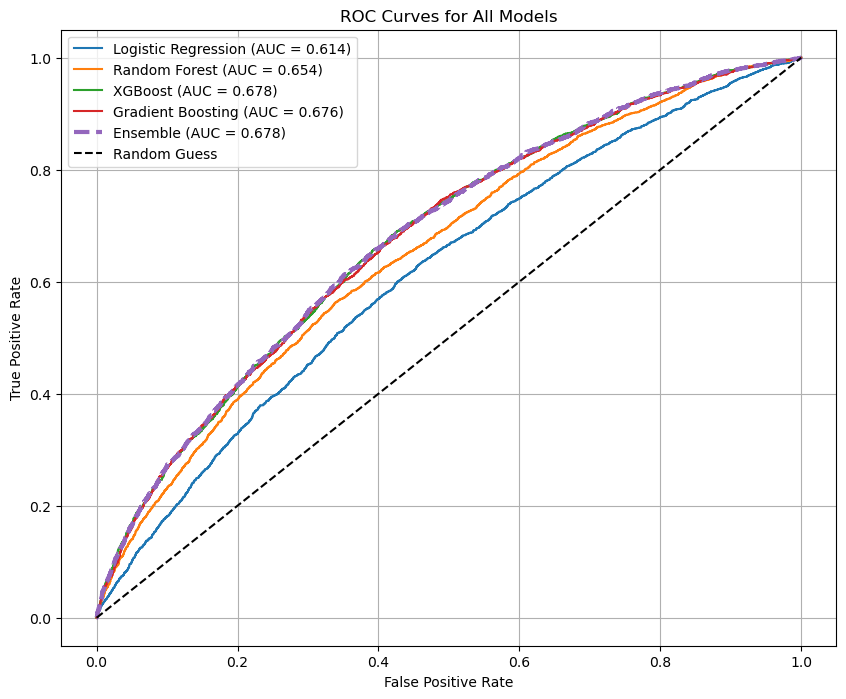

In [14]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Plot individual model ROC curves
for model_name, y_prob in model_predictions.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    model_auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {model_auc:.3f})')

# Plot ensemble ROC curve
fpr, tpr, _ = roc_curve(y_test, ensemble_pred)
plt.plot(fpr, tpr, label=f'Ensemble (AUC = {ensemble_auc:.3f})', linestyle='--', linewidth=3)

# Plot random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Save model metrics for dashboard
model_metrics = {}

for model_name, y_prob in model_predictions.items():
    y_pred = (y_prob > 0.5).astype(int)
    model_auc = roc_auc_score(y_test, y_prob)
    
    # Get classification report as dict
    report = classification_report(y_test, y_pred, output_dict=True)
    
    model_metrics[model_name] = {
        'roc_auc': float(model_auc),
        'precision': float(report['weighted avg']['precision']),
        'recall': float(report['weighted avg']['recall']),
        'f1_score': float(report['weighted avg']['f1-score'])
    }

# Add ensemble metrics
ensemble_pred_binary = (ensemble_pred > 0.5).astype(int)
ensemble_report = classification_report(y_test, ensemble_pred_binary, output_dict=True)

model_metrics['Ensemble'] = {
    'roc_auc': float(ensemble_auc),
    'precision': float(ensemble_report['weighted avg']['precision']),
    'recall': float(ensemble_report['weighted avg']['recall']),
    'f1_score': float(ensemble_report['weighted avg']['f1-score'])
}

# Save metrics to JSON file
import json
metrics_path = os.path.join(os.path.dirname(MODELS_DIR), 'dashboard', 'model_metrics.json')
os.makedirs(os.path.dirname(metrics_path), exist_ok=True)
with open(metrics_path, 'w') as f:
    json.dump(model_metrics, f, indent=4)

print(f"Model metrics saved to {metrics_path}")

Model metrics saved to C:\Users\alex5\Documents\Projects\telecom_churn_project\telecom_churn\dashboard\model_metrics.json


In [16]:
print(f"\nAll models have been successfully trained and saved to {MODELS_DIR}")
print("\nModels created:")
for i, model_name in enumerate(trained_models.keys(), 1):
    print(f"{i}. {model_name}")
print(f"{len(trained_models) + 1}. Ensemble Model (Weighted Blend)")


All models have been successfully trained and saved to C:\Users\alex5\Documents\Projects\telecom_churn_project\telecom_churn\models

Models created:
1. Logistic Regression
2. Random Forest
3. XGBoost
4. Gradient Boosting
5. Ensemble Model (Weighted Blend)
